In [2]:
import math
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import stumpy
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.decomposition import PCA
from src.datasets.dataset import Dataset

In [30]:
protein: str = "HNRNPC"
dataset = Dataset.read(f"./resources/datasets/{protein}")

[memo::read-4c47d5...] Storing hash.


In [4]:
dataset.pattern

,fshape_coefficient,base
0,0.00,NaN
1,1.25,T
2,1.15,T
3,3.00,T
4,1.70,T
5,0.10,NaN


In [5]:
expected_motif_length = len(dataset.pattern)
window_sizes = [expected_motif_length + x for x in range(3)]
window_sizes

[6, 7, 8]

In [6]:
dataset.sites[0].head()

,fshape_coefficient,base
0,NaN,C
1,NaN,T
2,NaN,T
3,NaN,T
4,NaN,T


In [7]:
def is_motif_promising(window: pd.Series) -> bool:
  return not window.isnull().any() and (window > 1).any()

In [8]:
promising_fshapes = defaultdict(list)
promising_motifs = defaultdict(list)

for site in dataset.sites:
  for window_size in window_sizes:
    for i in range(len(site) - window_size + 1):
      window = site.reactivity[i: i + window_size]

      if is_motif_promising(window):
        promising_fshapes[window_size].append(window.to_numpy())
        promising_motifs[window_size].append(site.base[i: i + window_size].to_numpy())

print(
  f"Example\nFshape: {promising_fshapes[window_sizes[0]][0]}\nMotif: {promising_motifs[window_sizes[0]][0]}"
)

Example
Fshape: [0.6515937  0.24909604 0.12207691 0.27174267 0.59119743 1.78560917]
Motif: ['A' 'C' 'C' 'T' 'A' 'A']


In [9]:
for key, value in promising_fshapes.items():
  print(f"For window size {key} there are {len(value)} promising motifs")

For window size 6 there are 667 promising motifs
For window size 7 there are 716 promising motifs
For window size 8 there are 757 promising motifs


[0.6515937  0.24909604 0.12207691 0.27174267 0.59119743 1.78560917]


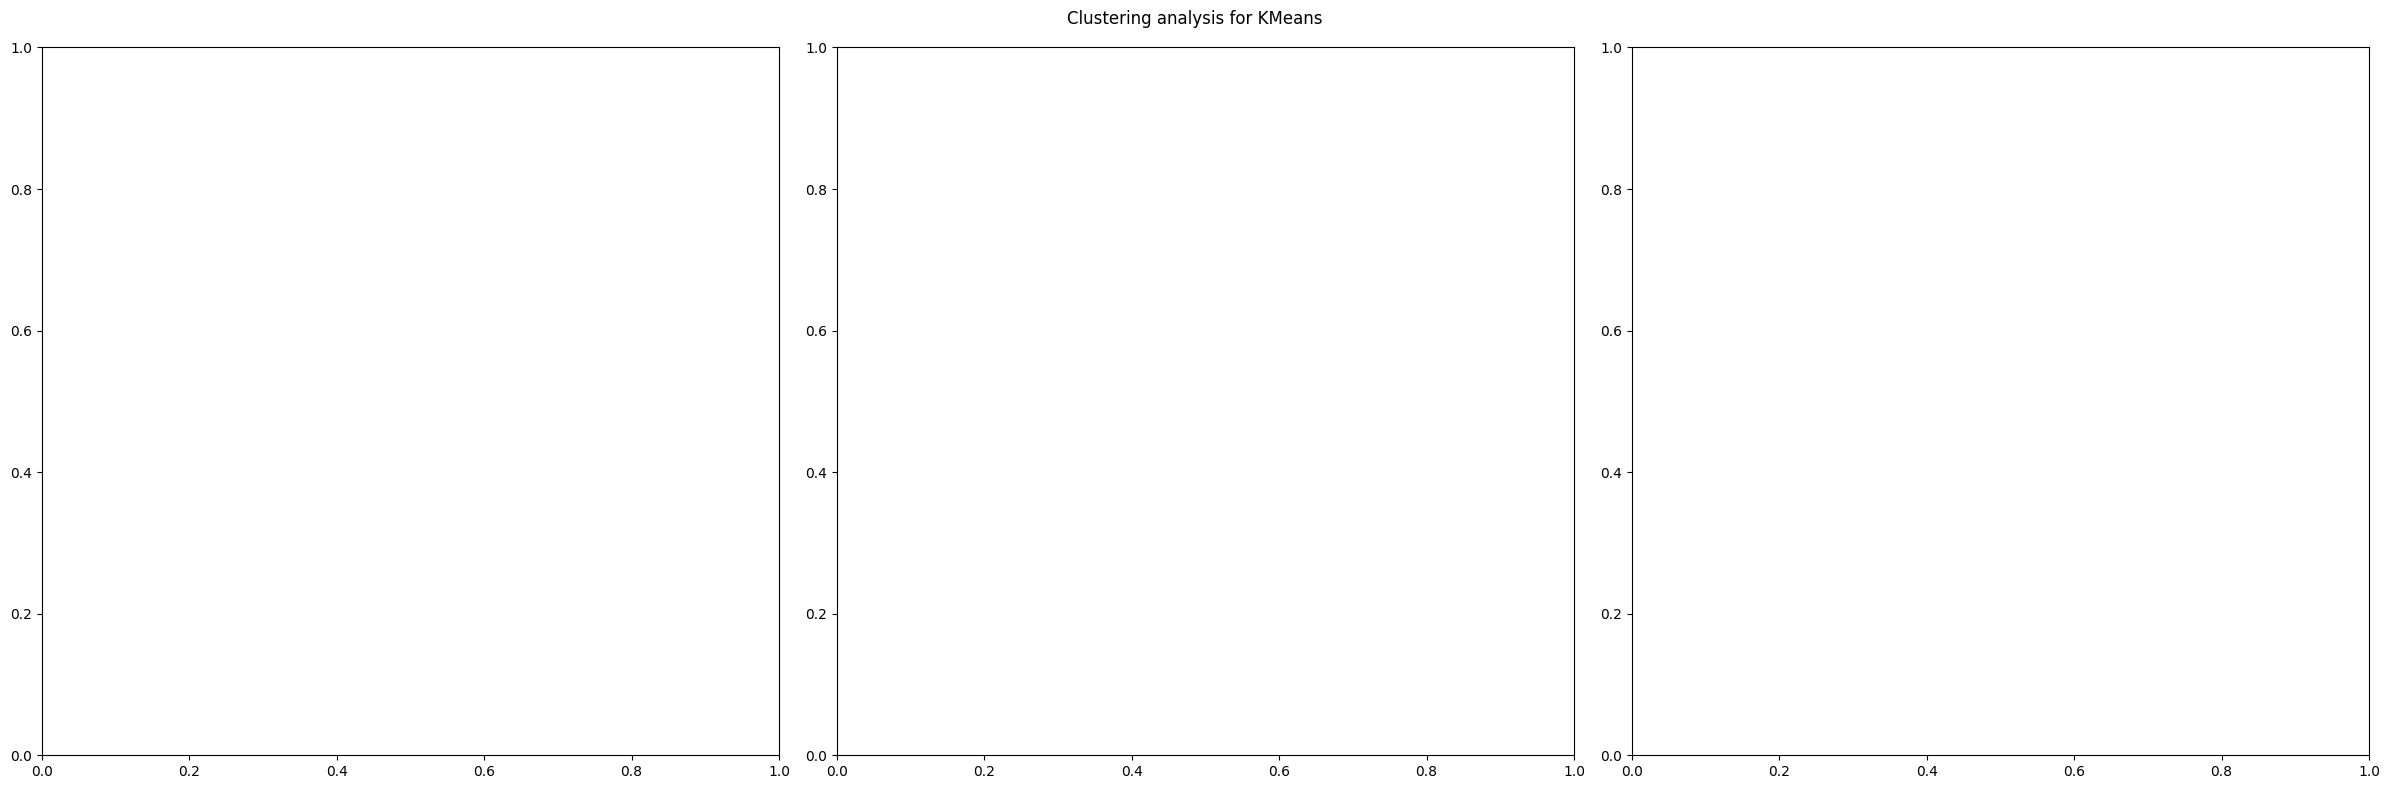

[0.6515937  0.24909604 0.12207691 0.27174267 0.59119743 1.78560917]


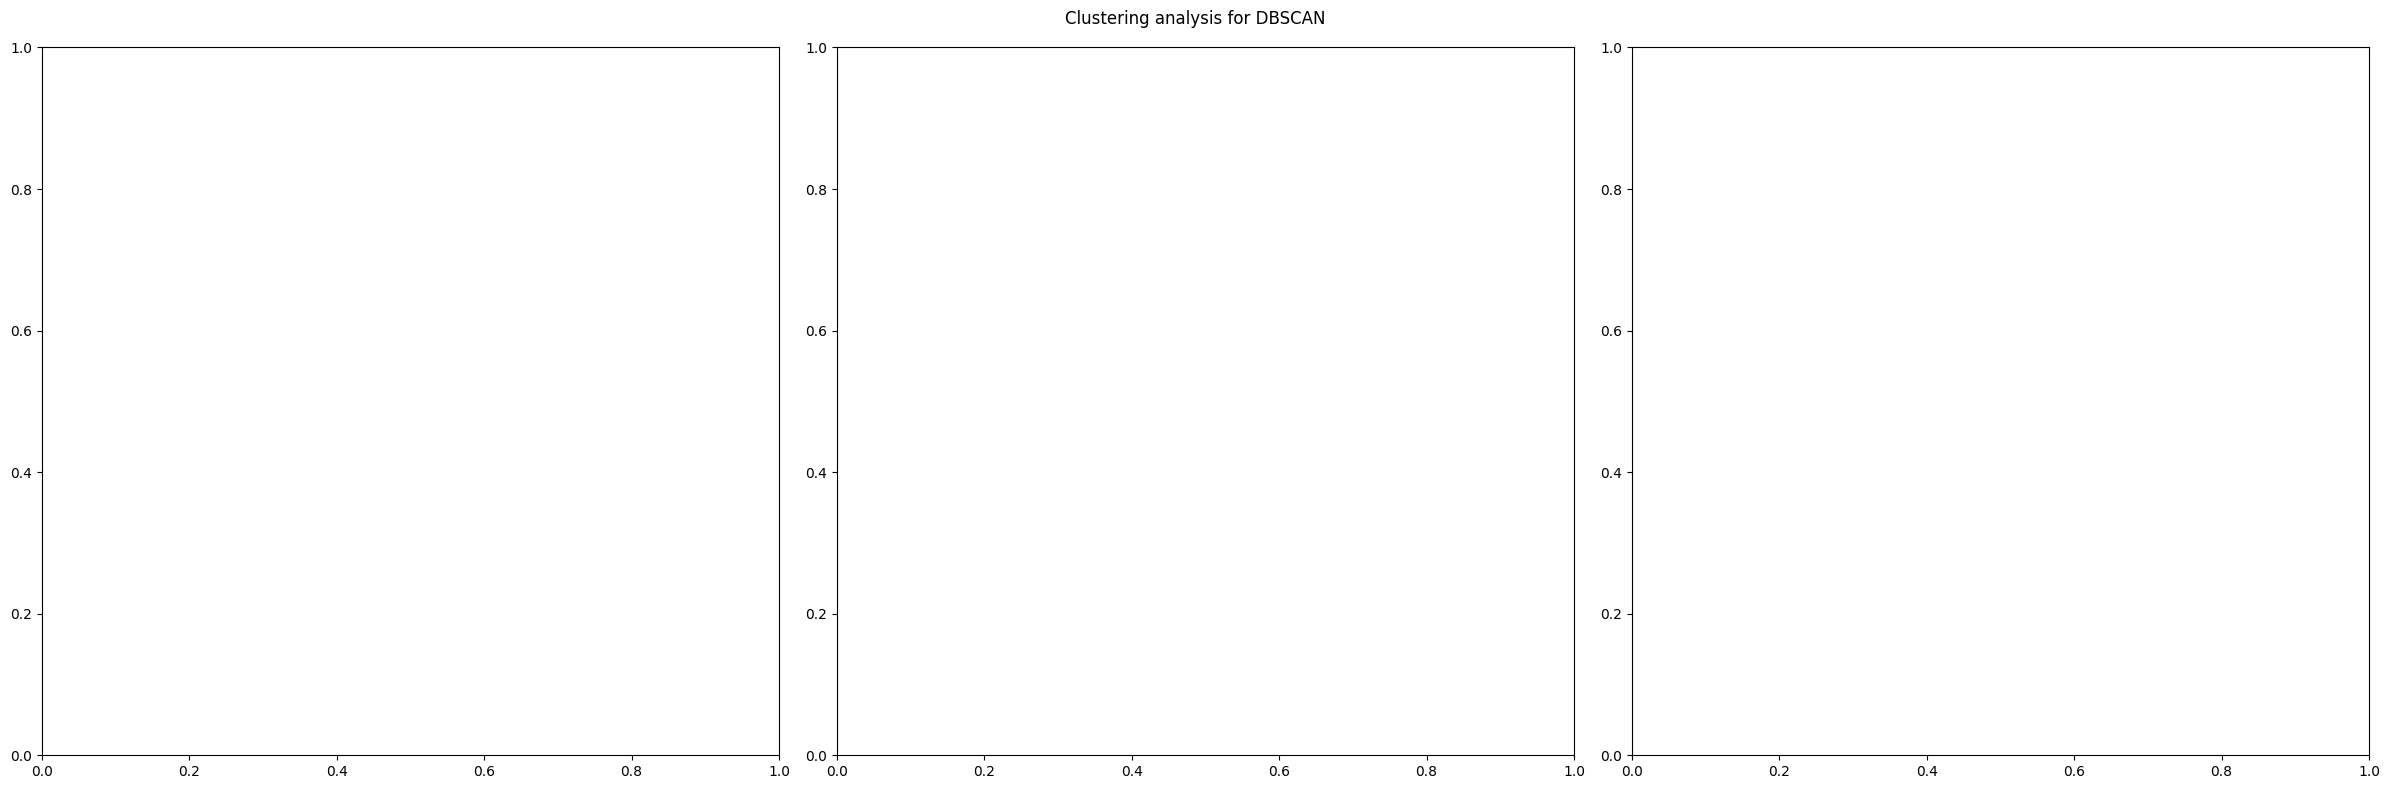

[0.6515937  0.24909604 0.12207691 0.27174267 0.59119743 1.78560917]


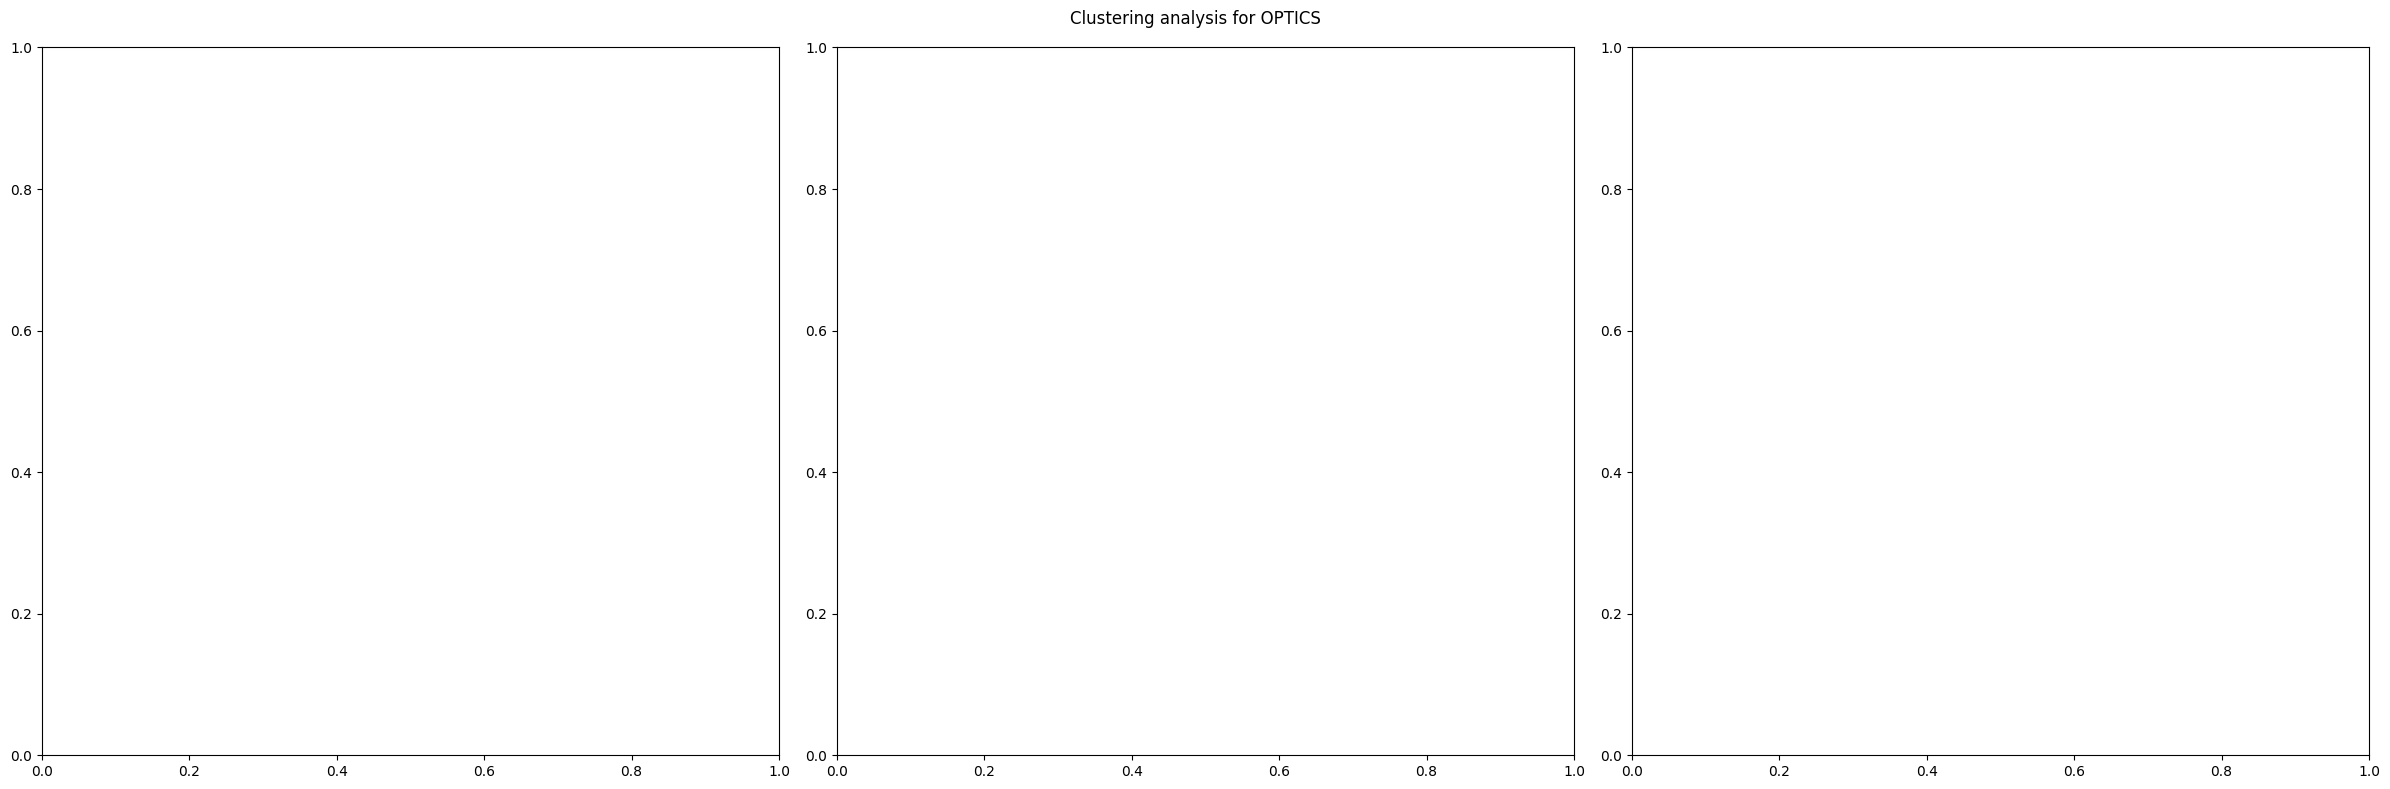

In [24]:
def perform_clustering_analysis(fshapes: defaultdict, model) -> None:
  fig, ax = plt.subplots(1, len(window_sizes), figsize=(24, 8), tight_layout=True)
  for i, window_size in enumerate(window_sizes):
    print(fshapes[window_size][0])
    break
    predicted = model.fit_predict(fshapes[window_size])
    pca = PCA(n_components=2)
    fshapes_reduced = pca.fit_transform(fshapes[window_size])

    ax[i].scatter(fshapes_reduced[:, 0], fshapes_reduced[:, 1], c=predicted, alpha=0.5)
    ax[i].set_title(
      f"Window size: {window_size}. Explained variance: {sum(pca.explained_variance_ratio_) * 100:.2f}%"
    )
    ax[i].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)")
    ax[i].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)")
    ax[i].grid(linestyle="--", linewidth=0.5, alpha=0.5)
    #  TODO: think if log scale is better for this case
    ax[i].set_xscale("log")

    if model.__class__.__name__ == "KMeans":
      cluster_centers = pca.transform(model.cluster_centers_)
      ax[i].scatter(
        cluster_centers[:, 0], cluster_centers[:, 1], marker="x", color="red", s=50
      )

  plt.suptitle(f"Clustering analysis for {model.__class__.__name__}")
  plt.show()


models = {
  "KMeans++": KMeans(n_clusters=3, init="k-means++", random_state=42),
  "DBSCAN": DBSCAN(eps=0.8, min_samples=3),
  "OPTICS": OPTICS(min_samples=3),
  # TODO: find better parameters (maybe elbow method for KMeans) and change 3rd model
}

for name, model in models.items():
  perform_clustering_analysis(promising_fshapes, model)

In [11]:
def get_most_numerous_clusters(
    predicted: np.ndarray, window_size: int, n_clusters: int = 3
) -> list:
  cluster_counts = Counter(predicted)
  cluster_counts.pop(-1, None)
  most_common_clusters = cluster_counts.most_common(n_clusters)
  print(f"Clusters for window size {window_size}: {most_common_clusters}")
  return [label for label, _ in most_common_clusters]


consensus_fshapes = [dataset.pattern.reactivity.to_numpy()]
consensus_motifs = [dataset.pattern.base.to_string(na_rep="N", index=False).replace("\n", "")]

for window_size in window_sizes:
  fshapes = np.array(promising_fshapes[window_size])
  motifs = np.array(promising_motifs[window_size])

  predicted = models["OPTICS"].fit_predict(fshapes)
  clusters = get_most_numerous_clusters(predicted, window_size)

  for cluster in clusters:
    cluster_fshapes = fshapes[predicted == cluster].tolist()
    cluster_motifs = motifs[predicted == cluster]

    _, idx, _ = stumpy.ostinato(cluster_fshapes, window_size)
    consensus_fshapes.append(cluster_fshapes[idx])
    consensus_motifs.append("".join(cluster_motifs[idx]))

    print(f"Consensus motif for cluster {cluster}: {''.join(cluster_motifs[idx])}")

Clusters for window size 6: [(5, 11), (26, 6), (29, 6)]
Consensus motif for cluster 5: CATTTT
Consensus motif for cluster 26: TAAAAT
Consensus motif for cluster 29: ATTGTT
Clusters for window size 7: [(8, 12), (3, 9), (15, 7)]
Consensus motif for cluster 8: AAACAGA
Consensus motif for cluster 3: CCGGTGT
Consensus motif for cluster 15: TCACCTC
Clusters for window size 8: [(5, 10), (1, 9), (11, 5)]
Consensus motif for cluster 5: AAACAGAC
Consensus motif for cluster 1: AATGGTAA
Consensus motif for cluster 11: AGCTGAGC


In [12]:
def calculate_ssf(first_motif: str, second_motif: str) -> float:
  group_matches = ("AG", "CU", "CT")
  ssf_sum: int = 0
  for first, second in zip(first_motif, second_motif):
    if first == second or first == "N" or second == "N":
      ssf_sum += 2
      continue
    for group in group_matches:
      if first in group and second in group:
        ssf_sum += 1
        break
  return ssf_sum / len(first_motif)


math.isclose(round(calculate_ssf("NTTTTN", "TGATTT"), 2), 1.33)

True

In [28]:
def get_ssf(motif: str, window_size: int) -> float:
  base = dataset.pattern.base.to_string(na_rep="N", index=False).replace("\n", "")
  centered_base = base.center(window_size, "N")
  print(base, centered_base)
  templates = set([centered_base, centered_base[::-1]])
  return max(calculate_ssf(motif, template) for template in templates)


def get_aS(znEd: float, ssf: float) -> float:
  return 10 * znEd - ssf


results: list = []

for search in dataset.searches:
  for consensus_fshape, consensus_motif in zip(consensus_fshapes, consensus_motifs):
    motif_length = len(consensus_motif)
    for i in range(len(search) - motif_length + 1):
      window = search.iloc[i: i + motif_length, :]
      znEd = stumpy.core.mass(consensus_fshape, window.reactivity)[0]

      if not is_motif_promising(window.reactivity) or znEd > 2.5:
        continue

      motif = window.base.to_string(na_rep="N", index=False).replace("\n", "")
      ssf = get_ssf(motif, window_size)
      aS = get_aS(znEd, ssf)

      results.append(
        {
          "motif": consensus_motif,
          "sequence": motif,
          "start": i,
          "end": i + motif_length,
          "filename": "",
          "znEd": znEd,
          "ssf": ssf,
          "aS": aS,
        }
      )
      break
    break
  break


NTTTTN NNTTTTNN


In [29]:
results = pd.DataFrame(results)
results.sort_values("aS", inplace=True)
results

,motif,sequence,start,end,filename,znEd,ssf,aS
0,NTTTTN,CAGCGC,170,176,,2.379663,1.0,22.796626


In [14]:
fshapes

array([[-0.62017746, -0.0073148 ,  0.6515937 , ...,  0.27174267,
         0.59119743,  1.78560917],
       [-0.0073148 ,  0.6515937 ,  0.24909604, ...,  0.59119743,
         1.78560917,  0.39179433],
       [ 0.6515937 ,  0.24909604,  0.12207691, ...,  1.78560917,
         0.39179433,  0.79621568],
       ...,
       [-0.2043604 , -0.16714633,  0.79686116, ...,  0.80661308,
         1.34917741,  0.28326026],
       [-0.16714633,  0.79686116,  0.89704032, ...,  1.34917741,
         0.28326026,  1.45980023],
       [ 0.79686116,  0.89704032,  0.832794  , ...,  0.28326026,
         1.45980023,  0.76355553]])